In [121]:
from scipy.spatial import KDTree
import pandas as pd
import geopandas as gpd
from pytz import UTC
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from typing import Union
import numpy.typing as npt
from typing import List, Tuple
import seaborn as sns
from shapely.geometry import Point, box
from matplotlib.lines import Line2D
from geopandas.tools import sjoin, sjoin_nearest
from scipy.spatial import KDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
from sklearn import svm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression

# Ignore divide by NaN warnings for normalisation from StandardScaler
np.seterr(divide='ignore', invalid='ignore')

# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

start = pd.Timestamp('2023-06-01 01:00:00', tz=UTC)
end = start + pd.Timedelta(days=30)
crs = 4326

def create_dataset_for_sensor_id(start, end, neighbours_gdf, sensor_id, freq, provider, nn_count, path, min_values=10, save=True, features: Union[str, List[str], None] = None, use_p_id_labels: bool = False, neighbour_ids: Union["pd.Series[str]", "pd.Series[int]", None] = None) -> pd.DataFrame :
    """
    Creates X and y datasets for a given sensor id.

    Parameters
    ----------
    start : pd.Timestamp
        The start time of the dataset
    end : pd.Timestamp
        The end time of the dataset
    neighbours_gdf : geopandas.GeoDataFrame
        The dataframe with the neighbours
    sensor_id : str
        The sensor id
    freq : int
        The frequency of the dataset in minutes
    provider : str
        The provider of the data
    nn_count : int
        The number of nearest neighbours to include
    path : str
        The path to save the dataset to
    min_values : int
        The minimum number of values in the dataset
    save : bool
        Whether to save the dataset to a file
    features : numpy.ndarray
        The features to include in the dataset. Can be None, "time", "humidity", "pressure",  a combination of those or "all" for all features.
    use_p_id_labels : bool
        If set to false, the p_ids of the neigbours are replaced with integer labels ordered by ascending distance. If set to true, the p_ids are used as labels based on feature: {feature}_{p_id}.
    neighbour_ids : list of str
        A list of p_ids to include in the dataset. The order of the ids is used as the label for the neighbours, e.g. the first neighbour is labelled with 1, and the columns are called ta_1, etc. If None, the ids of nn_count neigbours are used ordered by distance ascending. The sensor_id is always included.

    Information
    -------
    features:
        time: The time of day as a continuous value. The timestamp needs to be in the column 'time'. This column is only added once to the dataset.
        humidity: The humidity of the sensor. The humidity needs to be in the column 'humidity'. This column is added nn_count times to the dataset, once for each neighbour. If the value is missing, it is replaced with NaN.
        pressure: The pressure of the sensor. The pressure needs to be in the column 'pressure'. This column is added nn_count times to the dataset, once for each neighbour. If the value is missing, it is replaced with NaN.

    """

    X_data = []

    neighbours_gdf = neighbours_gdf.sort_values(by=['distance'])

    if neighbour_ids is None:
        neighbour_ids = pd.Series(neighbours_gdf['p_id'].unique()[0:nn_count + 1])

    for date in pd.date_range(start=start, end=end, freq=f'{freq}min'):
        start_time = date.to_datetime64()
        end_time = start_time + pd.Timedelta(minutes=freq)

        filtered_gdf = neighbours_gdf.copy()
        filtered_gdf = filtered_gdf[(filtered_gdf['time'] >= start_time) & (filtered_gdf['time'] < end_time)]
        filtered_gdf.set_index('p_id', inplace=True)

        if filtered_gdf.empty:
            continue

        feature_values = []

        if features is not None:
            if features == "all":
                features = ["time", "humidity", "pressure"]
            for feature in features:
                if feature == "time":
                    # Convert time to time of day
                    filtered_gdf['time'] = filtered_gdf['time'].apply(lambda x: (x.hour * 60 + x.minute) * 2 * np.pi / (24 * 60))
                    filtered_gdf.rename(columns={'time': 'time_angle'}, inplace=True)

                    # Calculate continuous representation of time as an angle in radians
                    filtered_gdf['sin_time'] = np.sin(filtered_gdf['time_angle'])
                    # First is y, then nn_count ta, then features
                    feature_values.append(filtered_gdf['sin_time'].values[0])
                if feature == "humidity":
                    for index, p_id in neighbour_ids.items():
                        if p_id in filtered_gdf.index:
                            feature_values.append(filtered_gdf.loc[p_id].humidity)
                        else:
                            feature_values.append(np.nan)
                if feature == "pressure":
                    for index, p_id in neighbour_ids.items():
                        if p_id in filtered_gdf.index:
                            feature_values.append(filtered_gdf.loc[p_id].pressure)
                        else:
                            feature_values.append(np.nan)

        feature_count = len(feature_values)
        column_count = 1 + nn_count + feature_count
        x = np.full(column_count, np.nan, dtype=object)
        x = np.append(x, feature_values)

        columns = ['y']

        if use_p_id_labels:
            columns.extend(['ta_' + neighbour_ids[i] for i in range(1, nn_count + 1)])
        else:
            columns.extend(['ta_' + str(i) for i in range(1, nn_count + 1)])

        # TODO: add correct feature names
        columns.extend(['feature_' + str(i) for i in range(1, feature_count + 1)])

        # neighbours need to be ordered by distance, so closest neighbour is first.
        # each p_id should only occur once in the filtered dataframe.
        for index, p_id in neighbour_ids.items():
            if p_id in filtered_gdf.index:
                ta_values = filtered_gdf.loc[p_id].ta

                if isinstance(ta_values, pd.Series):
                    x[index] = ta_values.values.mean()
                elif isinstance(ta_values, float):
                    x[index] = ta_values
                else:
                    raise Exception(f'Invalid type for ta_values: {type(ta_values)}')

        # Skip if the target value is missing
        if np.isnan(x[0]):
            continue

        new = pd.DataFrame([x], columns=columns)

        if new.y.isnull().values.any():
            print(f'NaN values in dataset for sensor {sensor_id} with {len(new.values)} entries')
    
        X_data.append(new)
    
    if len(X_data) == 0:
        print(f'No data for sensor {sensor_id} with {len(X_data)} entries')
        return
    
    if len(X_data) < min_values:
        print(f'Not enough data for sensor {sensor_id} with {len(X_data)} entries')
        return

    X = pd.concat(X_data, axis=0, ignore_index=True)
    
    if save:
        file_name = f'./data/testsets/{path}/{provider}/{sensor_id}_dataset.csv'
        print(f'Saving dataset for sensor {sensor_id} with {len(X.values)} entries to {file_name}')

        X.to_csv(file_name, index=False)
        
    return X

def get_neighbour_distances_from_coords(coords: tuple, tree: KDTree, nn_count: int = 11):
    """
    Returns a dataframe with the distances to k-nearest neighbours in km (approximated).

    Parameters
    ----------
    coords : tuple of longitude and latitude
        The coordinates to find the nearest neighbours for
    tree : scipy.spatial.KDTree
        The tree to query
    nn_count : int
        The number of nearest neighbours to find
    """

    dist, idx = tree.query(coords, k=nn_count + 1, p=2)

    idx = idx[0]
    # Multiply each distance by 111 to roughly get km from lon/lat euclidean distance.
    dist = dist[0] * 111
    distance_df = pd.DataFrame(zip(idx, dist), columns=["index", "distance"])
    distance_df.set_index("index", inplace=True)
    return distance_df

def create_neighbour_df(tree: KDTree, coords: tuple, p_ids_df: pd.DataFrame, parent_gdf: gpd.GeoDataFrame, target_p_id: Union[str, None] = None, nn_count: int = 11, min_distance: float=0.0, simulated_sensors: Union[dict, None] = None, neighbour_ids: Union[List[str], None] = None) -> Union[gpd.GeoDataFrame, None]:
    """
    Returns a dataframe with all rows from parent_gdf whose p_id is in k-nearest neighbours to a given point with a minimum distance.
    The closest point to the coordinates is the target station and is included in the dataframe.

    Parameters
    ----------
    tree : scipy.spatial.KDTree
        The tree to query
    coords : tuple of longitude and latitude
        The coordinates to find the nearest neighbours for
    p_ids_df : pandas.DataFrame
        A dataframe with the p_ids of the parent_gdf
    nn_count : int
        The number of nearest neighbours to find. If neighbour_ids is set, this is ignored.
    p_ids_df : pandas.DataFrame
        A dataframe with the p_ids of the parent_gdf
    parent_gdf : geopandas.GeoDataFrame
        The dataframe to filter
    min_distance : float
        The minimum distance to the target station
    simulated_sensors : dict
        A dictionary with p_ids as keys and the number of samples to simulate as values. If the value is an int, the number of samples taken from the dataframe with that p_id. If the value is a string, the dataframe is resampled with the given string as frequency, with the first value being taken. If the value is None, the p_id is completely removed from the dataframe.
    neighbour_ids : list of str
        A list of p_ids to include in the dataframe. If None, all nn_count neigbours are included. The target_p_id is always included. If set, only the p_ids in the list are included and the nn_count is ignored.
    """

    distance_df = get_neighbour_distances_from_coords(coords, tree, 150)

    nearest_df = distance_df.join(p_ids_df, how="inner")
    nearest_df.sort_values(by=['distance'], inplace=True)

    # Filter out neighbours that are too close
    min_distance_gdf = nearest_df[nearest_df['distance'] > min_distance]
    neighbours_gdf = parent_gdf.copy()

    if neighbour_ids is None:
        neighbour_ids = min_distance_gdf['p_id'].unique()[1:nn_count + 1]

    if target_p_id is None:
        neighbours_gdf = parent_gdf[(parent_gdf['p_id'].isin(neighbour_ids))]
    else:
        neighbours_gdf = parent_gdf[(parent_gdf['p_id'].isin(neighbour_ids)) | (parent_gdf['p_id'] == target_p_id)]

    # Add distance column
    neighbours_gdf = neighbours_gdf.merge(nearest_df, on='p_id', how='inner', suffixes=('', '_right'))
    neighbours_gdf.drop(columns=['geometry_right'], inplace=True)

    # Resample certain p_ids to simulate missing data
    if simulated_sensors is not None:
        for p_id, sample_setting in simulated_sensors.items():
            if p_id in neighbours_gdf['p_id'].values:
                # If set to all, keep all samples
                if sample_setting is not None and isinstance(sample_setting, str) and sample_setting.lower() == "all":
                    continue

                p_id_df = neighbours_gdf[neighbours_gdf['p_id'] == p_id]

                if isinstance(sample_setting, int):
                    # Make sure to not draw more samples than there are
                    if len(p_id_df) < sample_setting:
                        sample_setting = len(p_id_df)
                        print(f'Warning: Not enough samples for p_id {p_id}, using {sample_setting} samples instead')

                    p_id_df = p_id_df.sample(n=sample_setting, replace=False, random_state=42)
                elif isinstance(sample_setting, str):
                    # Todo: Not working as expected
                    p_id_df = p_id_df.resample(sample_setting, on='time').first()
                elif sample_setting is None:
                    neighbours_gdf = neighbours_gdf[neighbours_gdf['p_id'] != p_id]
                    continue
                else:
                    raise Exception(f'Invalid sample setting: {sample_setting}')
                
                neighbours_gdf = neighbours_gdf[neighbours_gdf['p_id'] != p_id]
                neighbours_gdf = pd.concat([neighbours_gdf, p_id_df])

    return neighbours_gdf

def plot_neighbours_min_distance(crs, gdf_nearest, target_p_id, zoom='auto'):
    fig, ax = plt.subplots(figsize=(10,10))

    # gdf_nearest.plot(ax=ax)
    target_df = gdf_nearest[gdf_nearest['p_id'] == target_p_id]
    # min_distance_gdf.plot(ax=ax)

    gdf_nearest.plot(marker='o', ax=ax, markersize=15, column='distance', legend=True)
    target_df.plot(marker='x', ax=ax, markersize=30, color='#e41a1c')
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

    # zoom = ctx.tile._calculate_zoom(*gdf_nearest.total_bounds)
    ctx.add_basemap(
        ax,
        crs=crs,
        zoom=zoom,
        alpha=0.7,
        source=ctx.providers.Stamen.TonerLines
    )

    return fig, ax

# Helpers

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [5]:
crs_hamburg = 'EPSG:3857'
crs_stuttgart = 'EPSG:4326'

def load_hamburg_netatmo_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Loads the Netatmo data for Hamburg from June 2023 including the QV results.
    Takes ca. 30 secs.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    m5_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have passed QC level m5
    rest_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have not passed QC level m5

    Information
    -------
    The bounding box for Hamburg is:
        lat_ne=53.65326&lon_ne=10.15370&lat_sw=53.48455&lon_sw=9.86917
    """

    df = pd.read_csv('./data/netatmo/june_hamburg/hamburg_06_23_after_qc.csv', parse_dates=['time'])

    df.drop('z', axis=1, inplace=True)

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[1], row[0]), axis=1), crs=crs_stuttgart)

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

def load_sensor_community_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Load all sensor community data from June 2023 for Germany including the QC results.
    This can take a while.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    """


    df = pd.read_csv('./data/sensor.community/2023-06_all_qc_after.csv', parse_dates=['time'])
    df.drop('z', axis=1, inplace=True) # drop z as it is empty anyways

    # If you want to filter by bounding box, set this to True and set appropriate lat lon values.
    filter_by_bounding_box = False

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs_stuttgart)
    
    if filter_by_bounding_box:
        # Stuttgart bounding box
        lat1, lon1 = 48.9519, 8.8402
        lat2, lon2 = 48.4698, 9.5348

        # # Create a bounding box geometry
        bounding_box = box(lon1, lat1, lon2, lat2)
    
        qc_gdf = qc_gdf[qc_gdf.geometry.within(bounding_box)]

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

def load_stuttgart_sensor_community_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Returns the sensor community data for Stuttgart from June 2023 including the QC results.
    Takes ca. 1 minute to load.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    m5_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have passed QC level m5
    rest_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have not passed QC level m5

    Information
    -------
    The bounding box for Stuttgart is:
        lat_ne=48.9519&lon_ne=9.5348&lat_sw=48.4698&lon_sw=8.8402
    """
    df = pd.read_csv('./data/sensor.community/stuttgart_06_23_after_qc.csv', parse_dates=['time'])

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs_stuttgart)
    
    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

stuttgart_gdf, stuttgart_m5_gdf, stuttgart_rest_gdf = load_stuttgart_sensor_community_data()
hamburg_gdf, hamburg_m5_gdf, hamburg_rest_gdf = load_hamburg_netatmo_data()

# Set to use only a specific location for testing.
qc_gdf, m5_gdf, rest_gdf = hamburg_gdf, hamburg_m5_gdf, hamburg_rest_gdf

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

print(len(locations))

713


# Build Dataset for Areal Interpolation

In [3]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize()


Successfully saved authorization token.


Load Stuugart Sensor.Community Data

In [214]:
### Load dataset
from shapely.geometry import box
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
from shapely.geometry import Point, box

np.set_printoptions(linewidth=110)
pd.set_option('display.width', 300)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

# Stuttgart bounding box
lat1, lon1 = 48.9519, 8.8402
lat2, lon2 = 48.4698, 9.5348

# Hamburg
# lat1, lon1 = 53.65326, 9.86917
# lat2, lon2 = 53.48455, 10.15370

# # Create a bounding box geometry
bounding_box = box(lon1, lat1, lon2, lat2)

proj_wgs = 'EPSG:4326'
# Temperature data after QC
df = pd.read_csv(f'./data/sensor.community/2023-06_all_qc_after.csv', delimiter=",", parse_dates=['time'])

# Additional data from before QC
df_before = pd.read_csv(f'./data/sensor.community/2023-06_all_qc_test_2.csv', delimiter=";", parse_dates=['timestamp'])

df_day = df[df['time'] == '2023-06-19 14:00:00']
df_day_before = df_before[df_before['timestamp'] == '2023-06-19 14:00:00']

df_night = df[df['time'] == '2023-06-19 05:00:00']
df_night_before = df_before[df_before['timestamp'] == '2023-06-19 05:00:00']

gdf_day = GeoDataFrame(df_day, geometry=df_day[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

gdf_night = GeoDataFrame(df_night, geometry=df_night[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

# Only keep rows inside bounding box
gdf_day = gdf_day[gdf_day.geometry.within(bounding_box)].set_index('p_id')
gdf_night = gdf_night[gdf_night.geometry.within(bounding_box)].set_index('p_id')

# Add humidity and pressure data from before df
gdf_day_before = GeoDataFrame(df_day_before, geometry=df_day_before[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

gdf_night_before = GeoDataFrame(df_night_before, geometry=df_night_before[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

# Only keep rows inside bounding box

gdf_day_before = gdf_day_before[gdf_day_before.geometry.within(bounding_box)].set_index('sensor_id')
gdf_night_before = gdf_night_before[gdf_night_before.geometry.within(bounding_box)].set_index('sensor_id')

# Add humidity and pressure data from before df
gdf_day = gdf_day.join(gdf_day_before[['humidity', 'pressure']], how='outer')
gdf_night = gdf_night.join(gdf_night_before[['humidity', 'pressure']], how='outer')

# Small QC
gdf_day['humidity'] = gdf_day['humidity'].apply(lambda x: np.nan if x == 1.0 else x)
gdf_night['humidity'] = gdf_night['humidity'].apply(lambda x: np.nan if x == 1.0 else x)

gdf_day = gdf_day[gdf_day["m5"] == True]
gdf_day.drop(columns=['z','m1','m2','m3','m4','m5','isolated'], inplace=True)

gdf_night = gdf_night[gdf_night["m5"] == True]
gdf_night.drop(columns=['z','m1','m2','m3','m4','m5','isolated'], inplace=True)

print(gdf_day.head())
print(gdf_night.head())

                   time    lon     lat      ta                  geometry  humidity    pressure
113 2023-06-19 14:00:00  9.182  48.808  29.130  POINT (9.18200 48.80800)    45.175  97745.4300
141 2023-06-19 14:00:00  9.160  48.778  33.385  POINT (9.16000 48.77800)    32.410  98122.0175
152 2023-06-19 14:00:00  9.164  48.792  29.100  POINT (9.16400 48.79200)    60.300         NaN
210 2023-06-19 14:00:00  9.120  48.810  29.150  POINT (9.12000 48.81000)    52.875         NaN
292 2023-06-19 14:00:00  9.162  48.776  34.700  POINT (9.16200 48.77600)    59.950         NaN
                   time    lon     lat       ta                  geometry  humidity    pressure
113 2023-06-19 05:00:00  9.182  48.808  22.1725  POINT (9.18200 48.80800)    73.205  97821.1275
141 2023-06-19 05:00:00  9.160  48.778  23.0275  POINT (9.16000 48.77800)    63.425  98225.1100
152 2023-06-19 05:00:00  9.164  48.792  22.7500  POINT (9.16400 48.79200)    77.675         NaN
210 2023-06-19 05:00:00  9.120  48.810  23.400

Load Netatmo Stuttgart Data (19.06.23)

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily

# Read netatmo data
df = pd.read_csv("data/netatmo/june_stuttgart/stuttgart_19_06_23_14_00_00.csv", sep=";", parse_dates=["time"])
netatmo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lat, df.lon), crs=proj_wgs)

# Convert columns to float also for rows windstrength, windangle, guststrength, gustangle
netatmo_df["temperature"] = netatmo_df["temperature"].astype(float)
netatmo_df["humidity"] = netatmo_df["humidity"].astype(float)
netatmo_df["pressure"] = netatmo_df["pressure"].astype(float)
netatmo_df["windstrength"] = netatmo_df["windstrength"].astype(float)
netatmo_df["windangle"] = netatmo_df["windangle"].astype(float)
netatmo_df["guststrength"] = netatmo_df["guststrength"].astype(float)
netatmo_df["gustangle"] = netatmo_df["gustangle"].astype(float)
netatmo_df["rain"] = netatmo_df["rain"].astype(float)

# Convert timestamp to datetime
# netatmo_df["time"] = pd.to_datetime(netatmo_df["time"])
netatmo_df = netatmo_df[netatmo_df['time'] == '2023-06-19 15:00:00'] # offset by 1 hour due to timezone and wrong handling

netatmo_df.dropna(subset=['temperature'], inplace=True)

min= 27.0
max= 35.5

print(len(netatmo_df))

netatmo_df = netatmo_df[(netatmo_df['temperature'] >= min) & (netatmo_df['temperature'] <= max)]

print(len(netatmo_df))

netatmo_df = netatmo_df[netatmo_df.geometry.within(bounding_box)].set_index('station_id')

print(len(netatmo_df))

print(netatmo_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

netatmo_df.plot(ax=ax, marker='o', color='royalblue', markersize=3)

ax.set_title('Netatmo Sensor Locations Stuttgart')

# Add basemap
contextily.add_basemap(
    ax,
    crs=proj_wgs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)

1578
1423
523
                                       time        lon       lat  temperature  pressure  humidity  windstrength  windangle  guststrength  gustangle  rain                  geometry
station_id                                                                                                                                                                         
70:ee:50:00:12:08 2023-06-19 15:00:00+02:00  48.494800  9.520600         30.0    1069.2      52.0           NaN        NaN           NaN        NaN   0.0  POINT (9.52060 48.49480)
70:ee:50:00:22:38 2023-06-19 15:00:00+02:00  48.615123  9.484629         29.3    1017.8      48.0           NaN        NaN           NaN        NaN   NaN  POINT (9.48463 48.61512)
70:ee:50:00:25:dc 2023-06-19 15:00:00+02:00  48.809281  9.238850         31.4    1016.3      48.0           NaN        NaN           NaN        NaN   0.0  POINT (9.23885 48.80928)
70:ee:50:00:2a:e8 2023-06-19 15:00:00+02:00  48.688114  9.000095         31.0    1015.

Load Google EE Data

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import ee
from geopandas import GeoDataFrame, GeoSeries
from geopandas.tools import sjoin
# from src.google_ee_data_helpers import get_ndvi_data

# Stuttgart bounding box
# lat1, lon1 = 48.9519, 8.8402
# lat2, lon2 = 48.4698, 9.5348

lat1 = 48.9519
lon1 = 8.8402
lat2 = 48.4698
lon2 = 9.5348

region = ee.Geometry.BBox(lon1, lat2, lon2, lat1)

def get_dataset(dataset_name, start_date, end_date, region, scale, bands):
    dataset = (
        ee.ImageCollection(dataset_name)
        .filterDate(start_date, end_date)
    )

    dataset = dataset.select(bands)

    clipped_dataset = dataset.getRegion(region, scale).getInfo()

    df = ee_array_to_df(clipped_dataset, bands)

    return df

def get_ndvi_data(start_date, end_date):
    return get_dataset('MODIS/061/MOD13A1', start_date, end_date, region, 500, ['NDVI'])

def get_evi_data(start_date, end_date):
    return get_dataset('MODIS/061/MOD13A1', start_date, end_date, region, 500, ['EVI'])

def get_elevation_data(start_date, end_date):
    return get_dataset('COPERNICUS/DEM/GLO30', start_date, end_date, region, 500, ['DEM'])

def clip_to_region(image):
  return image.clip(region)

def point_grid_to_cells(gdf):
    """Converts a GeoDataFrame of points to a GeoDataFrame of polygons."""
    xmin, ymin, xmax, ymax= gdf.total_bounds

    x_cells = len(gdf.geometry.x.unique())
    cell_size = (xmax-xmin)/x_cells

    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(box(x0, y0, x1, y1))
    
    cell = GeoDataFrame(grid_cells, columns=['geometry'], crs=proj_wgs)
    return cell

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    # df = df[['time','datetime',  *list_of_bands]]
    df.drop(['time'], axis=1, inplace=True)

    gdf = GeoDataFrame(df, geometry=df[[
    'longitude', 'latitude']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

    cells = point_grid_to_cells(gdf)

    return sjoin(cells, gdf, how='left', predicate='contains').drop('index_right', axis=1)


# Hamburg
# lat1, lon1 = 53.65326, 9.86917
# lat2, lon2 = 53.48455, 10.15370

# # Create a bounding box geometry
bounding_box = box(lon1, lat1, lon2, lat2)

start_date = '2023-06-05'
end_date = '2023-06-11'

ndvi_df = get_ndvi_data(start_date, end_date)
evi_df = get_evi_data(start_date, end_date)
elevation_df = get_elevation_data('2006-01-01', '2011-05-31') # DEM data is only available until 2011-05-31

# Create combined for sensor.community
# exchange between gdf_day and gdf_night
combined_df = sjoin(gdf_night, ndvi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df = sjoin(combined_df, evi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df = sjoin(combined_df, elevation_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)

print(combined_df.head())

# Create combined for netatmo
combined_df_netatmo = sjoin(netatmo_df.drop(['rain'], axis=1), ndvi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df_netatmo = sjoin(combined_df_netatmo, evi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df_netatmo = sjoin(combined_df_netatmo, elevation_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)

print(combined_df_netatmo.head())

                   time    lon     lat       ta                  geometry  humidity    pressure    NDVI     EVI         DEM
113 2023-06-19 05:00:00  9.182  48.808  22.1725  POINT (9.18200 48.80800)    73.205  97821.1275  6171.0  4602.0  291.196869
141 2023-06-19 05:00:00  9.160  48.778  23.0275  POINT (9.16000 48.77800)    63.425  98225.1100  4362.0  2015.0  278.951447
292 2023-06-19 05:00:00  9.162  48.776  23.6000  POINT (9.16200 48.77600)    87.075         NaN  4362.0  2015.0  278.951447
152 2023-06-19 05:00:00  9.164  48.792  22.7500  POINT (9.16400 48.79200)    77.675         NaN  6222.0  4116.0  321.418579
210 2023-06-19 05:00:00  9.120  48.810  23.4000  POINT (9.12000 48.81000)    64.175         NaN  8004.0  4739.0  339.220367
                                       time        lon       lat  temperature  pressure  humidity  windstrength  windangle  guststrength  gustangle                  geometry    NDVI     EVI         DEM
station_id                                            

In [216]:
test_df = combined_df.copy()
test_df.reset_index(inplace=True)

nr_neighbours = 30

# Add neighbour temperatures
# Add sitances to neighbours
for i in range(1, nr_neighbours + 1):
    test_df[f'distance_{i}'] = np.nan
    test_df[f'ta_{i}'] = np.nan

locations = list(test_df['geometry'].apply(lambda x: (x.x, x.y)))
location_df = pd.DataFrame(locations)

# More build time but better query time
tree = KDTree(locations, balanced_tree=True)

for index, row in test_df.iterrows():
    coords = row["geometry"].coords
    distance_df = get_neighbour_distances_from_coords(coords, tree, nr_neighbours)

    # neighbours = test_df.merge(distance_df, how='inner', suffixes=('', '_right'))
    neighbours = test_df.loc[distance_df.index]
    distance_df.reset_index(inplace=True)

    for i, neighbour_row in distance_df.iloc[1:].iterrows():
        ind = int(neighbour_row['index'])
        distance = neighbour_row['distance']
        ta = combined_df.iloc[ind].ta
        row[f'ta_{i}'] = ta
        row[f'distance_{i}'] = distance

    test_df.loc[index] = row

test_df.fillna(-1, inplace=True)
display(test_df)

index                time       lon        lat         ta                  geometry  humidity      pressure    NDVI     EVI  ...  distance_26    ta_26  distance_27    ta_27  distance_28   ta_28  distance_29    ta_29  distance_30    ta_30
0      113 2023-06-19 05:00:00  9.182000  48.808000  22.172500  POINT (9.18200 48.80800)   73.2050  97821.127500  6171.0  4602.0  ...     4.188688  23.2500     4.310460  24.2250     4.310460  22.350     4.445547  24.0600     4.709331  23.9550
1      141 2023-06-19 05:00:00  9.160000  48.778000  23.027500  POINT (9.16000 48.77800)   63.4250  98225.110000  4362.0  2015.0  ...     4.264481  23.8250     4.270255  22.1750     4.270255  22.340     4.445547  21.5750     4.721308  21.3000
2      292 2023-06-19 05:00:00  9.162000  48.776000  23.600000  POINT (9.16200 48.77600)   87.0750     -1.000000  4362.0  2015.0  ...     4.188688  22.1725     4.218000  21.5750     4.241304  23.825     4.527929  22.3400     4.662000  22.3500
3      152 2023-06-19 05:00:00  9.164000  48.792000  22.750000  POINT (9.16400 48.79200)   77.6750     -1.000000  6222.0  4116.0  ...     4.782026  22.3500     4.842703  22.2500     4.852104  23.068     4.868840  22.9000     4.889043  20.9250
4      210 2023-06-19 05:00:00  9.120000  48.810000  23.400000  POINT (9.12000 48.81000)   64.1750     -1.000000  8004.0  4739.0  ...     7.203891  23.8250     7.220974  22.6750     7.302417  22.900     7.633902  21.4580     7.751456  22.2500
..     ...                 ...       ...        ...        ...                       ...       ...           ...     ...     ...  ...          ...      ...          ...      ...          ...     ...          ...      ...          ...      ...
145  70734 2023-06-19 05:00:00  9.252000  48.804000  22.425000  POINT (9.25200 48.80400)   57.6000     -1.000000  6858.0  4246.0  ...     6.622897  21.9400     6.678474  20.9000     6.838897  23.900     6.885580  23.8250     6.919707  23.3675
146  71105 2023-06-19 05:00:00  8.962000  48.716000  19.260000  POINT (8.96200 48.71600)   80.5400  96262.555000  7919.0  6546.0  ...    16.204479  20.8500    16.441494  19.6500    16.769452  20.145    16.803215  20.1575    17.271828  20.2500
147  76088 2023-06-19 05:00:00  9.048049  48.521025  21.581667  POINT (9.04805 48.52102)   59.9350  97784.323333  5839.0  3543.0  ...    19.613210  21.7500    19.621725  21.6250    20.270963  19.846    20.898083  20.7000    21.318079  21.1750
148  76611 2023-06-19 05:00:00  9.062000  48.534000  23.567500  POINT (9.06200 48.53400)   50.8650  96781.422500  6509.0  4668.0  ...    18.419312  21.7500    18.420515  20.4040    19.723048  20.700    21.152711  19.8460    21.208715  20.2625
149  79242 2023-06-19 05:00:00  9.118000  48.720000  19.715000  POINT (9.11800 48.72000)   63.9625  96602.585000  6386.0  3679.0  ...     7.905195  23.6000     7.948716  23.0275     8.004324  22.675     8.438921  22.6500     8.635201  23.8250

[150 rows x 71 columns]

## Comparison

In [217]:
# Day time gdf with all features: combined_df
results = []

for gdf in [test_df]:
    print(f"Starting with {gdf.time.values[0]}...")

    for regr in [LinearRegression(), KNeighborsRegressor(n_neighbors=30), RandomForestRegressor(n_estimators=200), HistGradientBoostingRegressor(max_iter=200), svm.SVR()]:
        X,y = gdf.drop(['time', 'geometry', 'ta'], axis=1).values, gdf['ta'].values

        # KNN is scale sensisitive, so all input features need to be scaled
        clf = make_pipeline(StandardScaler(), regr)
        rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)
        r2 = make_scorer(r2_score, greater_is_better=True, force_finite=True)
        scoring = {
            'rmse': rmse,
            'r2': "r2"
        }

        pipe = make_pipeline()
        scores = cross_validate(clf, X, y, cv=10, scoring=scoring)

        for i in range(9):
            new = pd.DataFrame({
                "time": gdf.time.values[0],
                "type": type(regr).__name__,
                "RMSE": scores['test_rmse'][i],
                "R2": scores['test_r2'][i]
                }, index=[0])
            
            results.append(new)

eval_df = pd.concat(results)
print(eval_df.head(11))

Starting with 2023-06-19T05:00:00.000000000...
                 time                 type      RMSE        R2
0 2023-06-19 05:00:00     LinearRegression  1.294213 -0.767590
0 2023-06-19 05:00:00     LinearRegression  0.753196  0.783944
0 2023-06-19 05:00:00     LinearRegression  0.859309  0.763891
0 2023-06-19 05:00:00     LinearRegression  1.011792  0.671043
0 2023-06-19 05:00:00     LinearRegression  1.031976  0.254978
0 2023-06-19 05:00:00     LinearRegression  1.153435  0.442009
0 2023-06-19 05:00:00     LinearRegression  1.038232  0.458882
0 2023-06-19 05:00:00     LinearRegression  0.882713  0.602353
0 2023-06-19 05:00:00     LinearRegression  0.932157  0.642485
0 2023-06-19 05:00:00  KNeighborsRegressor  1.277282 -0.721647
0 2023-06-19 05:00:00  KNeighborsRegressor  0.851339  0.723971


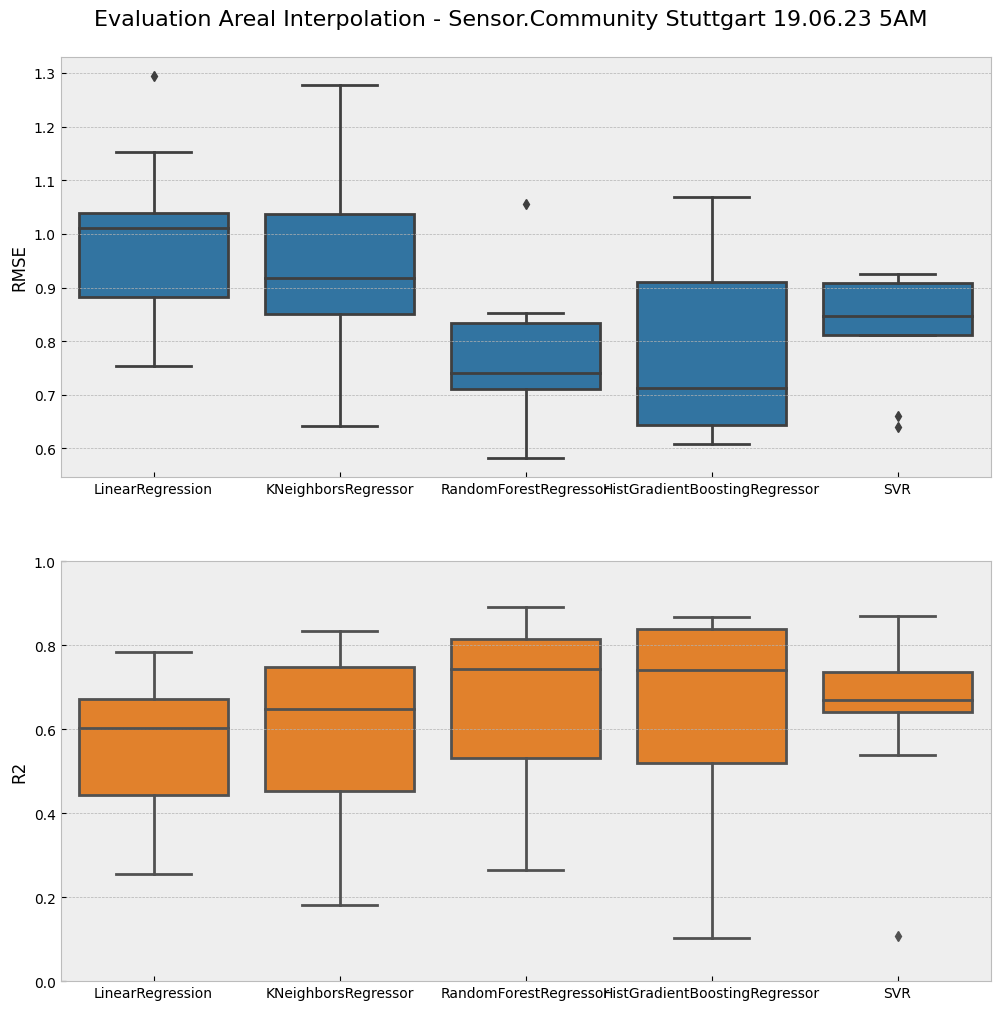

In [224]:
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle(F'Evaluation Areal Interpolation - Sensor.Community Stuttgart 19.06.23 5AM', fontsize=16, y=0.92)

eval_coords = eval_df[eval_df["time"] == "2023-06-19 14:00:00"]
eval_night = eval_df[eval_df["time"] == "2023-06-19 05:00:00"]

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
sns.boxplot(data=eval_night, x='type', y='RMSE', ax=axs[0], color=color_palette[0])
sns.boxplot(data=eval_night, x='type', y='R2', ax=axs[1], color=color_palette[1])

axs[0].set_xlabel(None)
axs[1].set_xlabel(None)

axs[0].set_ylabel('RMSE')
axs[1].set_ylabel('R2')
axs[1].set_ylim(0, 1)

# Create a custom legend for each subplot
# custom_lines = [Line2D([0], [0], color=color_palette[0], lw=2),
#                 Line2D([0], [0], color=color_palette[1], lw=2)]

# axs[0].legend(handles=custom_lines, labels=['RMSE', 'R2'], loc='upper right')
# axs[1].legend(handles=custom_lines, labels=['RMSE', 'R2'], loc='upper left')

plt.show()

## Map Generation

In [225]:
# We need the estimator (can get from cross_validation) and the scaler (cannot get cross_validation) so we need to recreate one regr and scaler per model here
regressors = []
scalers = []

ml_model_results = []

for regr in [KNeighborsRegressor(n_neighbors=30), RandomForestRegressor(n_estimators=100), HistGradientBoostingRegressor(max_iter=100, loss='squared_error'), svm.SVR()]:
    X,y = test_df.drop(['time', 'geometry', 'ta'], axis=1).values, test_df['ta'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1)

    scaler = StandardScaler().fit(X_train)
    X_train_norm = scaler.transform(X_train)
    X_test_norm = scaler.transform(X_test)

    regr.fit(X_train_norm, y_train)
    y_pred = regr.predict(X_test_norm)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f'RMSE for {type(regr).__name__}: {rmse}')
    print(f'R2 for {type(regr).__name__}: {r2}')

    regressors.append(regr)
    scalers.append(scaler)

    new = pd.DataFrame({
        "type": type(regr).__name__,
        "RMSE": rmse,
        "R2": r2
        }, index=[0])
    
    ml_model_results.append(new)

ml_model_results_df = pd.concat(ml_model_results)
print(ml_model_results_df.to_latex(index=False))

RMSE for KNeighborsRegressor: 0.9351469914061679
R2 for KNeighborsRegressor: 0.679537497295289
RMSE for RandomForestRegressor: 0.7303780567675813
R2 for RandomForestRegressor: 0.8045152460591013
RMSE for HistGradientBoostingRegressor: 0.7294552107207646
R2 for HistGradientBoostingRegressor: 0.8050089311031462
RMSE for SVR: 0.8047744087264285
R2 for SVR: 0.76266282240003
\begin{tabular}{lrr}
\toprule
                         type &     RMSE &       R2 \\
\midrule
          KNeighborsRegressor & 0.935147 & 0.679537 \\
        RandomForestRegressor & 0.730378 & 0.804515 \\
HistGradientBoostingRegressor & 0.729455 & 0.805009 \\
                          SVR & 0.804774 & 0.762663 \\
\bottomrule
\end{tabular}



/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_25713/4192942556.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ml_model_results_df.to_latex(index=False))


In [226]:
# Copy df with data as we edit rows
map_df_day_sc = combined_df.copy()

def create_cells(gdf):
    gdf.reset_index(inplace=True)
    gdf.fillna(-1, inplace=True)

    locations = list(gdf['geometry'].apply(lambda x: (x.x, x.y)))

    # More build time but better query time
    tree = KDTree(locations, balanced_tree=True)

    # Create empty point GeoDataFrame
    xmin, ymin, xmax, ymax= combined_df.total_bounds
    x_cells = 100

    cell_size = (xmax-xmin)/x_cells

    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(Point(x0, y0))

    cell = GeoDataFrame(grid_cells, columns=['geometry'], crs=proj_wgs)
    cells = point_grid_to_cells(combined_df)
    return tree,cell,cells

def create_area_interpolation_dataset(cell, cells, gdf):
    humidity_df = sjoin(cells, gdf, how='inner', predicate='intersects')
    dissolved = humidity_df.dissolve(by='index_right', aggfunc='mean')
    dissolved.drop(['NDVI', 'EVI', 'DEM'], axis=1, inplace=True)

    interpolation_df = sjoin(cell, ndvi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
    interpolation_df = sjoin(interpolation_df, evi_df, how='inner', predicate='within').drop(['index_right', 'longitude','latitude', 'datetime'], axis=1)
    interpolation_df = sjoin(interpolation_df, elevation_df, how='inner', predicate='within').drop(['index_right','datetime'], axis=1)
    interpolation_df = sjoin(interpolation_df, dissolved, how='left', predicate='within').drop(['index_right'], axis=1)

    interpolation_df['lon'] = interpolation_df.geometry.x
    interpolation_df['lat'] = interpolation_df.geometry.y

    interpolation_df.drop(['longitude','latitude'], axis=1, inplace=True)
    interpolation_df['predicted_ta'] = np.nan
    interpolation_df.reset_index(inplace=True, drop=True)

    # Add neighbour temperatures and distances for each cell
    nr_neighbours = 30

    # Add neighbour temperatures
    # Add sitances to neighbours
    for i in range(1, nr_neighbours + 1):
        interpolation_df[f'distance_{i}'] = np.nan
        interpolation_df[f'ta_{i}'] = np.nan

    for index, row in interpolation_df.iterrows():
        coords = row["geometry"].coords
        distance_df = get_neighbour_distances_from_coords(coords, tree, nr_neighbours + 1)

        # Check if there is a neighbour with distance 0
        if distance_df.iloc[0]['distance'] == 0:
            distance_df = distance_df.iloc[1:]
        else:
            distance_df = distance_df.iloc[:-1]

        distance_df.reset_index(inplace=True)

        for i, neighbour_row in distance_df.iterrows():
            ind = int(neighbour_row['index'])
            distance = neighbour_row['distance']
            ta = map_df_day_sc.iloc[ind].ta
            row[f'ta_{i}'] = ta
            row[f'distance_{i}'] = distance

        interpolation_df.loc[index] = row

    return interpolation_df

tree, cell, cells = create_cells(map_df_day_sc)
interpolation_df_day_sc = create_area_interpolation_dataset(cell, cells, map_df_day_sc)
interpolation_df_day_sc.fillna(-1, inplace=True)

interpolation_df_day_sc.drop(['geometry', 'index', 'ta'], axis=1, inplace=True)

# reorder to: lon, lat, humidity, pressure, NDVI, EVI, DEM, distance_1, ta_1, distance_2, ta_2, ... distance_30, ta_30
interpolation_df_day_sc = interpolation_df_day_sc[['lon', 'lat', 'humidity', 'pressure', 'NDVI', 'EVI', 'DEM', *interpolation_df_day_sc.columns[8:], 'predicted_ta']]

display(interpolation_df_day_sc)

/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


lon      lat  humidity  pressure    NDVI     EVI         DEM  distance_1     ta_1  distance_2  ...   ta_26  distance_27   ta_27  distance_28   ta_28  distance_29    ta_29  distance_30    ta_30  predicted_ta
0     8.8500  48.4820      -1.0      -1.0  6244.0  5029.0  479.483948   12.372393  20.2500   13.436895  ...  19.285    29.867045  20.150    29.990549  18.500    30.180571  19.6500    30.243222  20.2625          -1.0
1     8.8500  48.4887      -1.0      -1.0  6012.0  4373.0  479.674805   11.639074  20.2500   12.722432  ...  19.285    29.318479  20.150    29.416234  18.500    29.615769  20.2625    29.632237  19.6500          -1.0
2     8.8500  48.4954      -1.0      -1.0  5837.0  4510.0  471.097626   10.907161  20.2500   12.011518  ...  19.285    28.778676  20.150    28.849658  18.500    28.993814  20.2625    29.056137  20.0500          -1.0
3     8.8500  48.5021      -1.0      -1.0  6733.0  5835.0  469.443634   10.176957  20.2500   11.304824  ...  19.285    28.248139  20.150    28.291287  18.500    28.377719  20.2625    28.438020  20.0500          -1.0
4     8.8500  48.5088      -1.0      -1.0  6408.0  5074.0  463.123413    9.448858  20.2500   10.603193  ...  19.285    27.727400  20.150    27.741616  18.500    27.767873  20.2625    27.826051  20.0500          -1.0
...      ...      ...       ...       ...     ...     ...         ...         ...      ...         ...  ...     ...          ...     ...          ...     ...          ...      ...          ...      ...           ...
6433  9.5267  48.8706      -1.0      -1.0  6069.0  4175.0  275.222565   22.131532  23.2275   24.002515  ...  23.725    33.378062  24.125    33.403670  22.400    33.654360  20.9800    33.834129  22.6100          -1.0
6434  9.5267  48.8773      -1.0      -1.0  5583.0  3480.0  277.394623   22.265222  23.2275   24.207820  ...  22.400    33.505122  23.725    33.737177  20.756    33.942446  20.9800    33.978291  24.0000          -1.0
6435  9.5267  48.8840      -1.0      -1.0  5140.0  3204.0  278.926910   22.422794  23.2275   24.434045  ...  23.725    33.867934  21.025    34.125323  24.000    34.136893  20.7560    34.157083  22.6100          -1.0
6436  9.5267  48.8907      -1.0      -1.0  7128.0  4677.0  340.634613   22.603748  23.2275   24.680615  ...  23.725    34.283043  21.025    34.287859  24.000    34.341588  22.6100    34.547994  20.7560          -1.0
6437  9.5267  48.8974      -1.0      -1.0  8860.0  5724.0  436.369873   22.807529  23.2275   24.946926  ...  23.725    34.465679  24.000    34.541122  22.610    34.709125  21.0250    34.887646  20.9800          -1.0

[6438 rows x 68 columns]

lon      lat  humidity  pressure    NDVI     EVI         DEM  distance_1     ta_1  distance_2  ...  distance_27   ta_27  distance_28   ta_28  distance_29    ta_29  distance_30    ta_30  predicted_ta                  geometry
0     8.8500  48.4820      -1.0      -1.0  6244.0  5029.0  479.483948   12.372393  20.2500   13.436895  ...    29.867045  20.150    29.990549  18.500    30.180571  19.6500    30.243222  20.2625     21.767084  POINT (8.85000 48.48200)
1     8.8500  48.4887      -1.0      -1.0  6012.0  4373.0  479.674805   11.639074  20.2500   12.722432  ...    29.318479  20.150    29.416234  18.500    29.615769  20.2625    29.632237  19.6500     21.767084  POINT (8.85000 48.48870)
2     8.8500  48.4954      -1.0      -1.0  5837.0  4510.0  471.097626   10.907161  20.2500   12.011518  ...    28.778676  20.150    28.849658  18.500    28.993814  20.2625    29.056137  20.0500     21.767084  POINT (8.85000 48.49540)
3     8.8500  48.5021      -1.0      -1.0  6733.0  5835.0  469.443634   10.176957  20.2500   11.304824  ...    28.248139  20.150    28.291287  18.500    28.377719  20.2625    28.438020  20.0500     21.767084  POINT (8.85000 48.50210)
4     8.8500  48.5088      -1.0      -1.0  6408.0  5074.0  463.123413    9.448858  20.2500   10.603193  ...    27.727400  20.150    27.741616  18.500    27.767873  20.2625    27.826051  20.0500     21.767084  POINT (8.85000 48.50880)
...      ...      ...       ...       ...     ...     ...         ...         ...      ...         ...  ...          ...     ...          ...     ...          ...      ...          ...      ...           ...                       ...
6433  9.5267  48.8706      -1.0      -1.0  6069.0  4175.0  275.222565   22.131532  23.2275   24.002515  ...    33.378062  24.125    33.403670  22.400    33.654360  20.9800    33.834129  22.6100     21.767084  POINT (9.52670 48.87060)
6434  9.5267  48.8773      -1.0      -1.0  5583.0  3480.0  277.394623   22.265222  23.2275   24.207820  ...    33.505122  23.725    33.737177  20.756    33.942446  20.9800    33.978291  24.0000     21.767084  POINT (9.52670 48.87730)
6435  9.5267  48.8840      -1.0      -1.0  5140.0  3204.0  278.926910   22.422794  23.2275   24.434045  ...    33.867934  21.025    34.125323  24.000    34.136893  20.7560    34.157083  22.6100     21.767084  POINT (9.52670 48.88400)
6436  9.5267  48.8907      -1.0      -1.0  7128.0  4677.0  340.634613   22.603748  23.2275   24.680615  ...    34.283043  21.025    34.287859  24.000    34.341588  22.6100    34.547994  20.7560     21.767084  POINT (9.52670 48.89070)
6437  9.5267  48.8974      -1.0      -1.0  8860.0  5724.0  436.369873   22.807529  23.2275   24.946926  ...    34.465679  24.000    34.541122  22.610    34.709125  21.0250    34.887646  20.9800     -1.000000  POINT (9.52670 48.89740)

[6438 rows x 69 columns]

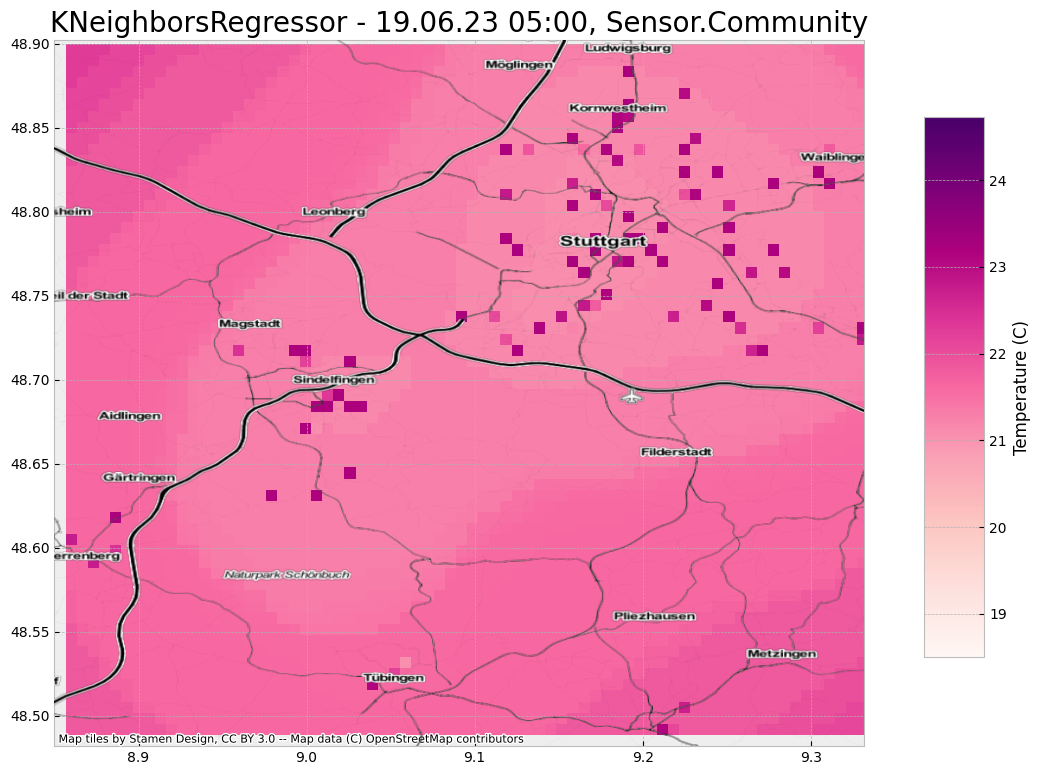

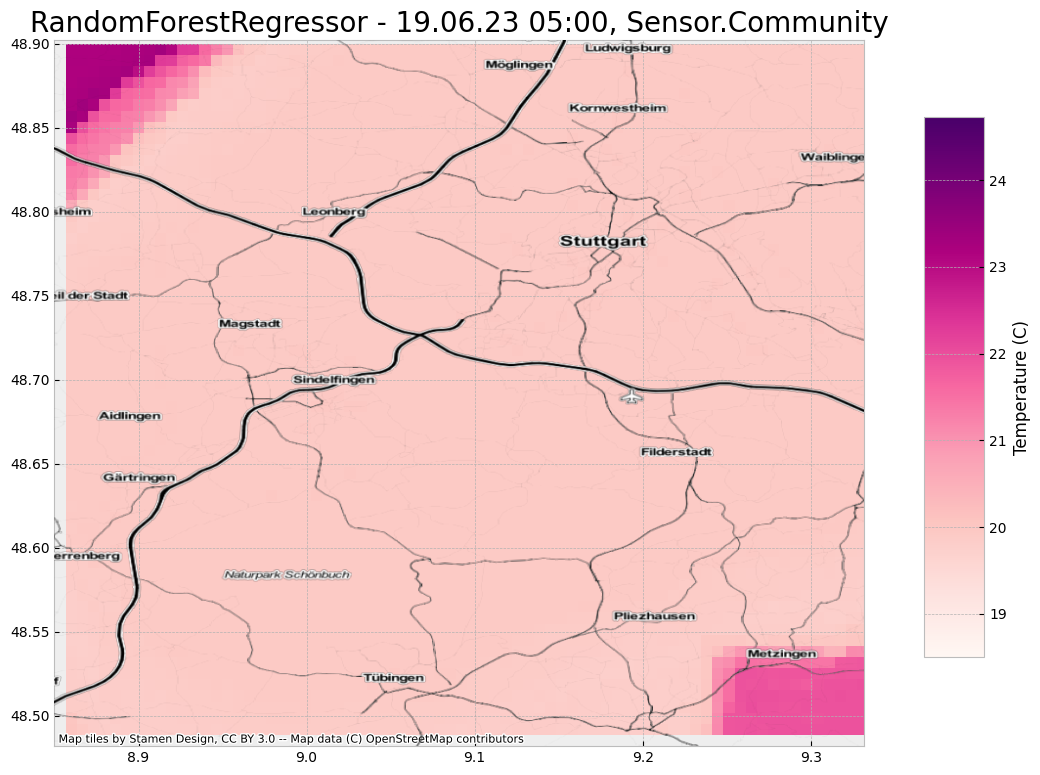

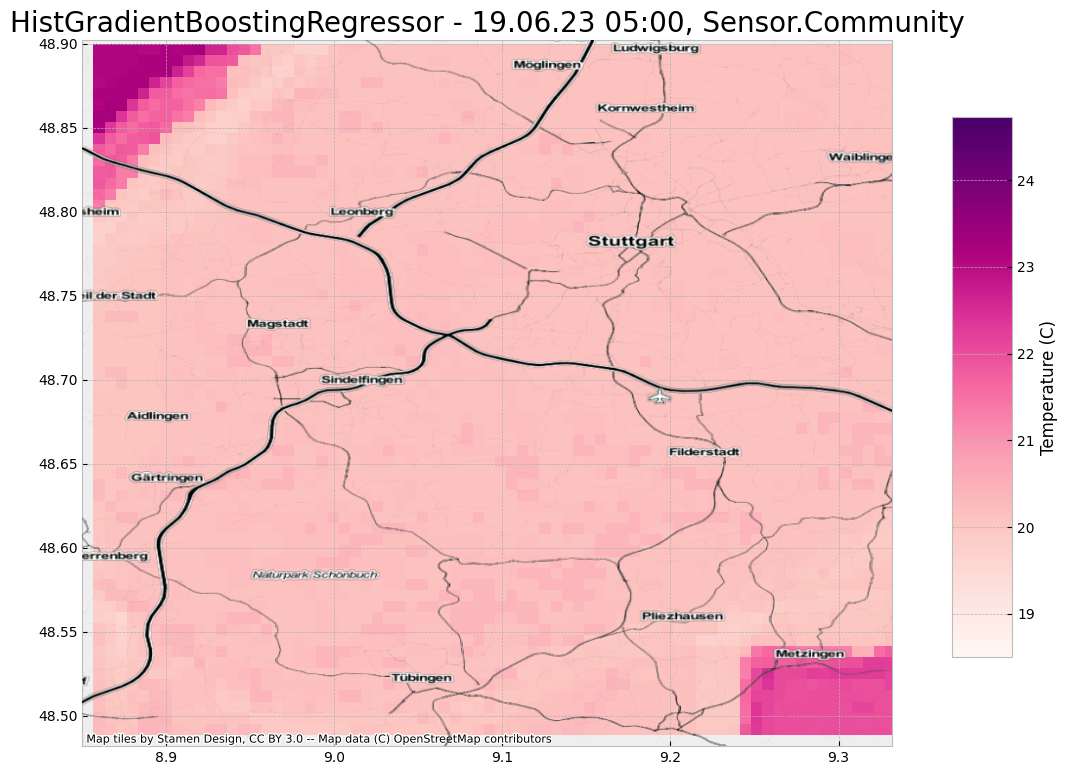

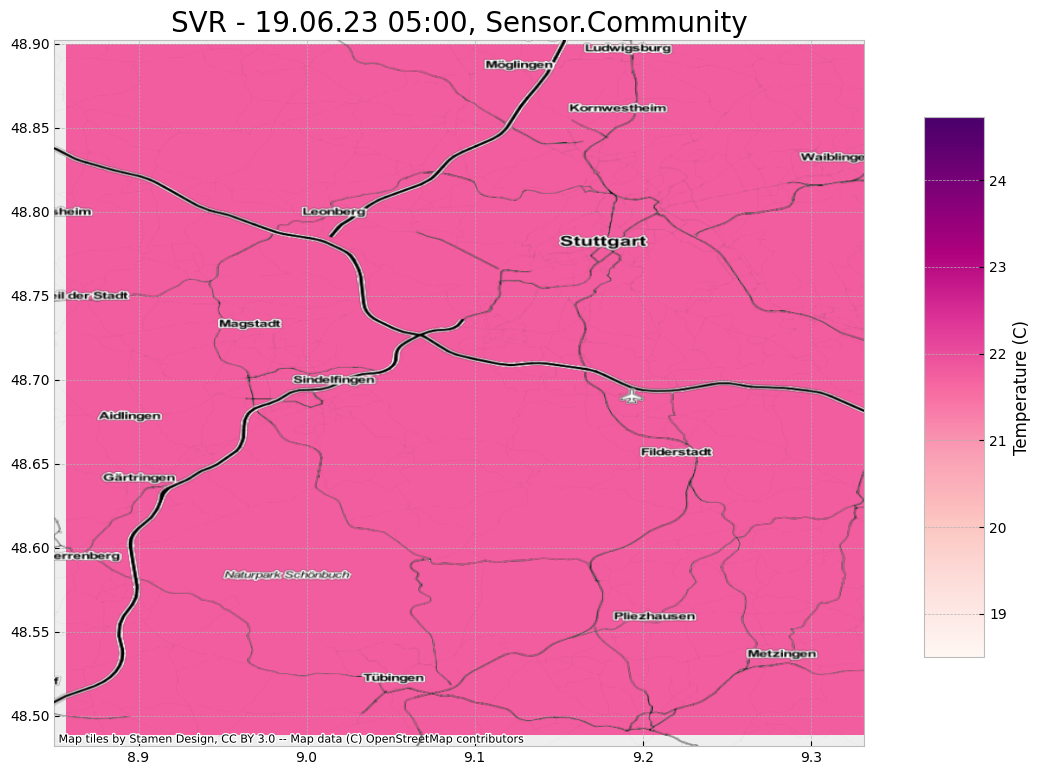

In [227]:
cmap = "RdPu"
vmin = np.min(combined_df.ta)
vmax = np.max(combined_df.ta)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

def plot_temperature_point_gdf(gdf, title, column='ta'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    gdf.plot(column=column, cmap=cmap, ax=ax, markersize=20, norm=norm)
    # stuttgart.boundary.plot(ax=ax, linewidth=1, color='black', aspect=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    fig.subplots_adjust(right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.275, 0.05, 0.45])

    # Display plot
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label='Temperature (C)')

    ax.set_title(title, fontsize=20)

    ctx.add_basemap(ax, crs=ndvi_df.crs.to_string(), source=contextily.providers.Stamen.TonerHybrid)

def interpolate_area(df, cells, scalar, regressor, title, min = None, max = None):
    test_df = df.copy()
    for index, row in interpolation_df_day_sc.iloc[:-1].iterrows():
    # Needs to be in order ['lon', 'lat', 'humidity', 'pressure', 'NDVI', 'EVI']
        to_predict = row.values.reshape(1, -1)
        to_predict_scaled = scalar.transform(to_predict, copy=True)
        predicted = regressor.predict(to_predict_scaled)
        test_df.at[index, 'predicted_ta'] = predicted

    interpolation_gdf = GeoDataFrame(test_df, geometry=test_df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs_stuttgart)

    cells = point_grid_to_cells(interpolation_gdf)
    gridded_interpolation_df = sjoin(cells, interpolation_gdf, how='inner', predicate='contains')

    plot_temperature_point_gdf(gridded_interpolation_df, title, column='predicted_ta')
    return interpolation_gdf

interpolate_area(interpolation_df_day_sc, cells, scalers[0], regressors[0], 'KNeighborsRegressor - 19.06.23 05:00, Sensor.Community')
interpolate_area(interpolation_df_day_sc, cells, scalers[1], regressors[1], 'RandomForestRegressor - 19.06.23 05:00, Sensor.Community')
interpolate_area(interpolation_df_day_sc, cells, scalers[2], regressors[2], 'HistGradientBoostingRegressor - 19.06.23 05:00, Sensor.Community')
interpolate_area(interpolation_df_day_sc, cells, scalers[3], regressors[3], 'SVR - 19.06.23 05:00, Sensor.Community')

# cmap = "RdPu"
# vmin = np.min(test.predicted_ta)
# vmax = np.max(test.predicted_ta)
# norm = plt.Normalize(vmin=vmin, vmax=vmax)

# interpolate_area(interpolation_df, cells, scalers[0], regressors[0], 'KNeighborsRegressor - 19.06.23 14:00, Sensor.Community')

## Ordinary Kriging - Reference

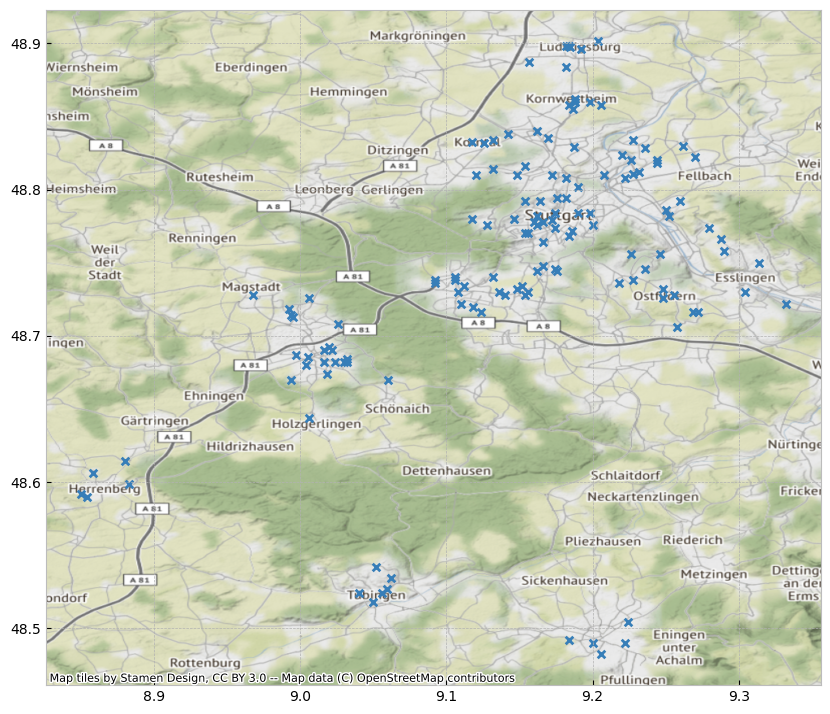

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

combined_df.plot(ax=ax, marker='x', color='#377eb8', markersize=30)

contextily.add_basemap(
        ax,
        crs=proj_wgs,
        # source=contextily.providers.Stamen.TonerHybrid,
    )

PyKrige Kriging out-of-sample r-squared for variogram model linear and target feature ta: -0.0
PyKrige Kriging RMSE for variogram model linear and target feature ta: 1.71
PyKrige Kriging out-of-sample r-squared for variogram model power and target feature ta: -0.0
PyKrige Kriging RMSE for variogram model power and target feature ta: 1.71
PyKrige Kriging out-of-sample r-squared for variogram model gaussian and target feature ta: 0.4
PyKrige Kriging RMSE for variogram model gaussian and target feature ta: 1.33
PyKrige Kriging out-of-sample r-squared for variogram model spherical and target feature ta: 0.45
PyKrige Kriging RMSE for variogram model spherical and target feature ta: 1.27
PyKrige Kriging out-of-sample r-squared for variogram model exponential and target feature ta: 0.26
PyKrige Kriging RMSE for variogram model exponential and target feature ta: 1.47


<Figure size 640x480 with 0 Axes>

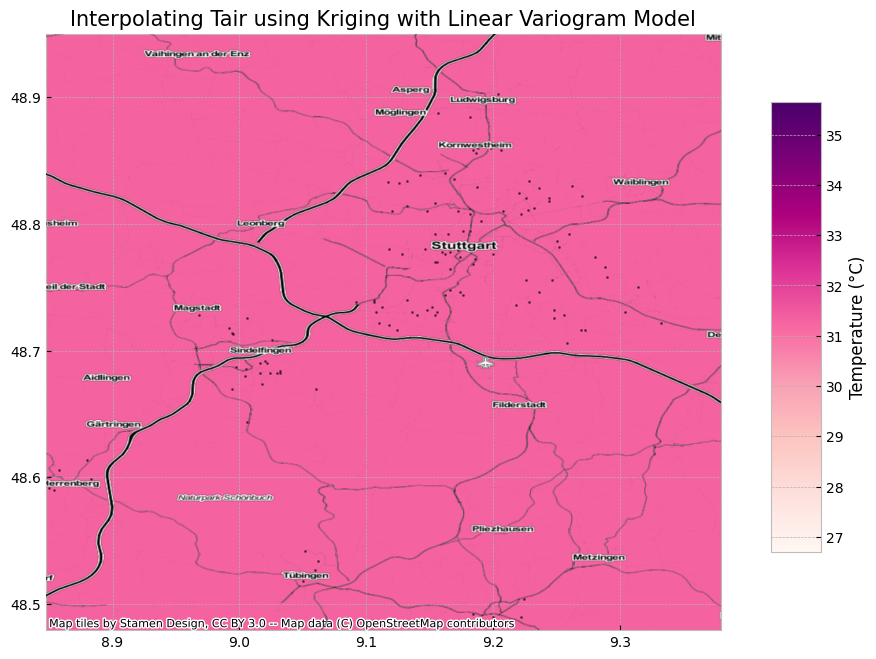

<Figure size 640x480 with 0 Axes>

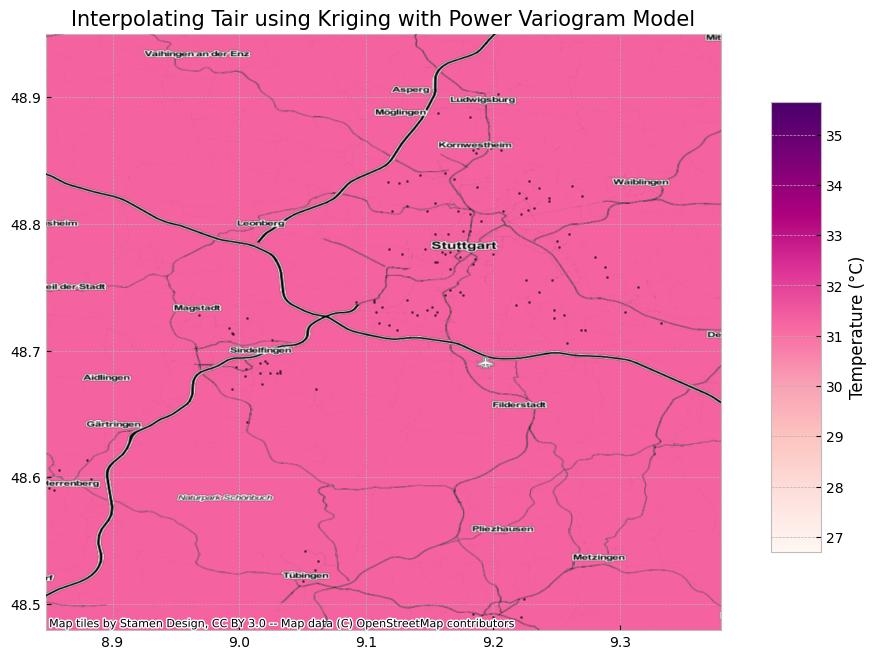

<Figure size 640x480 with 0 Axes>

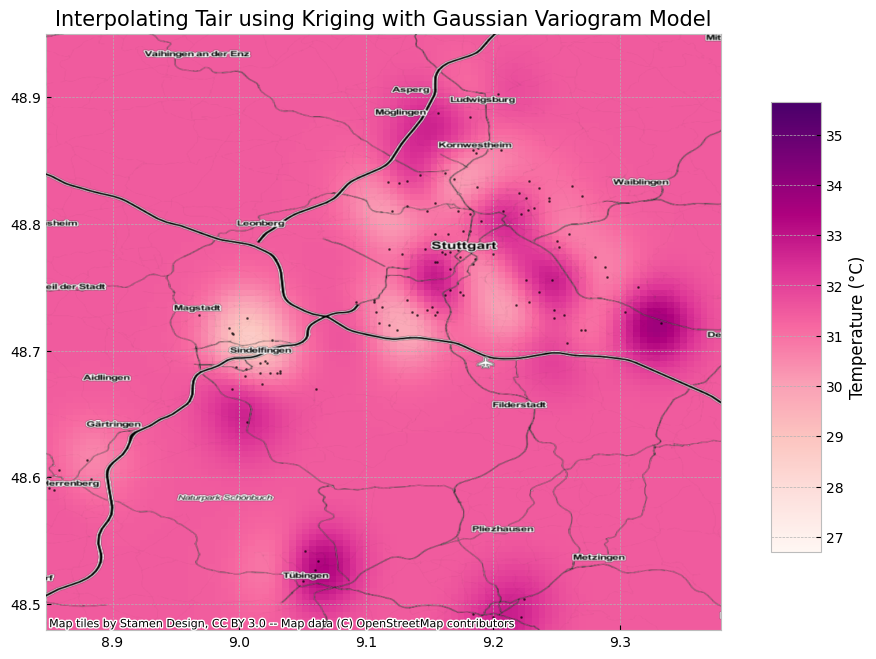

<Figure size 640x480 with 0 Axes>

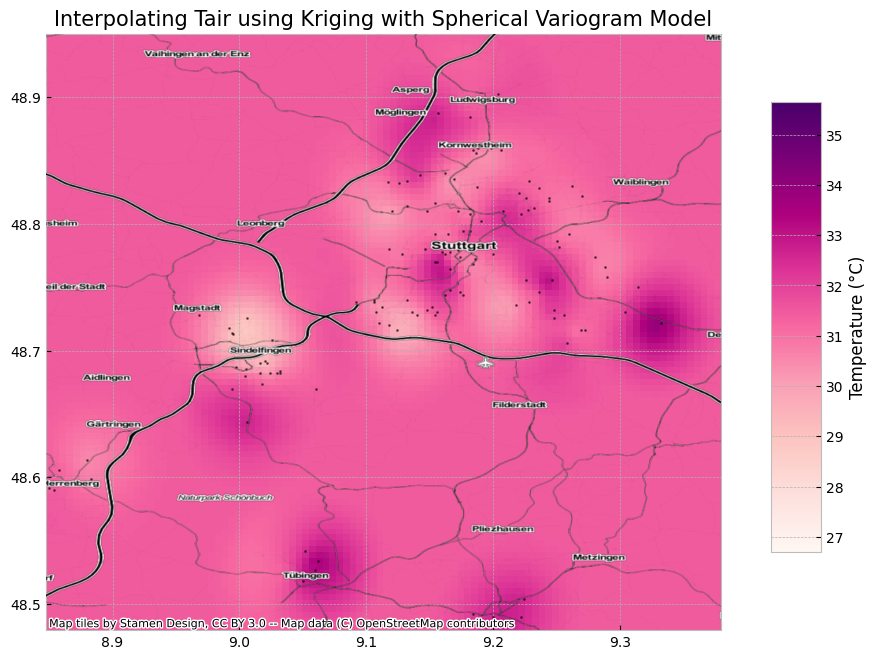

<Figure size 640x480 with 0 Axes>

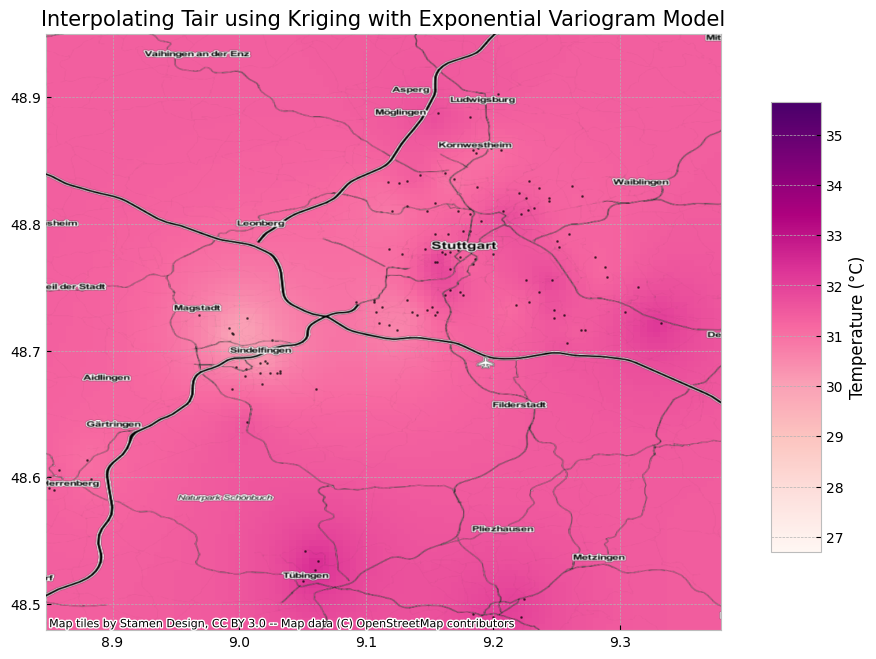

\begin{tabular}{lrr}
\toprule
variogram\_model &     RMSE &        R2 \\
\midrule
         linear & 1.712089 & -0.001049 \\
          power & 1.712089 & -0.001049 \\
       gaussian & 1.327896 &  0.397814 \\
      spherical & 1.272819 &  0.446732 \\
    exponential & 1.471249 &  0.260778 \\
\bottomrule
\end{tabular}



/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_25713/885074433.py:242: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(variogram_errors.to_latex(index=False))


In [213]:
import ast
from math import isnan
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from sklearn import preprocessing

variogram_results = []

def to_numpy_list(geo_series):
    return [[point.x, point.y]
            for point in geo_series.to_numpy()]

def geo_df_to_train_test_sets(gdf: gpd.GeoDataFrame, target_feature: str = 'ta') :
    """
    Splits a GeoDataFrame into train and test sets.
    :param gdf: The GeoDataFrame to split.
    :param target_feature: The name of the target feature. Can be any column in the GeoDataFrame: 'Temperature', 'Humidity', 'Pressure'.
    """
    coords_train, coords_test, value_train, value_test = train_test_split(
        gdf.geometry, gdf[target_feature], test_size=0.2, random_state=1)
    
    coords_train = to_numpy_list(coords_train)
    coords_test = to_numpy_list(coords_test)

    return coords_train, coords_test, value_train, value_test

def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(
        min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode="w",
            driver="GTiff",
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs=proj,
            transform=transform,
    ) as new_dataset:
        new_dataset.write(Z, 1)

# Define functions
def interpolate_ordinary_kriging(base_gdf: GeoDataFrame, variogram_model: str, target_feature: str = 'ta', normalize: bool = False):
    """
    Interpolate data using ordinary kriging.

    :param base_gdf: GeoDataFrame containing the data to be interpolated
    :param variogram_model: The variogram model to be used for interpolation. Possible values: linear, power, gaussian, spherical, exponential, hole-effect
    :param target_feature: The name of the target feature. Can be any column in the GeoDataFrame: 'Temperature', 'Humidity', 'Pressure'.
    """
    # Drop rows with missing values
    base_gdf = GeoDataFrame(base_gdf.dropna(subset=[target_feature]))

    # Normalize data
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        base_gdf[target_feature] = min_max_scaler.fit_transform(
            base_gdf[target_feature].values.reshape(-1, 1))

    x_coords = base_gdf.geometry.x
    y_coords = base_gdf.geometry.y

    coords_train, coords_test, value_train, value_test = geo_df_to_train_test_sets(
        base_gdf, target_feature)
    
    # Get outer bounds for data points
    minx, miny, maxx, maxy = base_gdf.total_bounds

    # # Add buffer to outer bounds
    # minx -= .2
    # miny -= .1
    # maxx += .2
    # maxy += .2

    maxx += .05
    maxy += .05

    # Create a 100 by 100 grid from the outer bounds
    grid_lon = np.linspace(minx, maxx, 100)
    grid_lat = np.linspace(miny, maxy, 100)

    # Generate ordinary krigin object
    OK = OrdinaryKriging(
        [item[0] for item in coords_train],
        [item[1] for item in coords_train],
        value_train,
        variogram_model=variogram_model,
        verbose=False,
        enable_plotting=False,
        coordinates_type="euclidean",
    )

    # Evaluate the method on grid
    Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", grid_lon, grid_lat)

    filename = f'./data/kriging/stuttgart_{target_feature}_krigin_{variogram_model}.tif'

    # Export raster
    export_kde_raster(Z=Z_pk_krig, XX=grid_lon, YY=grid_lat, min_x=minx, max_x=maxx, min_y=miny,
                  max_y=maxy, proj=proj_wgs, filename=filename)

    # Open raster
    raster_pk = rasterio.open(filename)

    # Create polygon with extend of raster
    poly_shapely = box(*raster_pk.bounds)

    # Create a dictionary with needed attributes and required geometry column
    attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}

    # Convert shapely object to a GeoDataFrame
    raster_pk_extent = GeoDataFrame(
        attributes_df, geometry='geometry', crs=proj_wgs)
    
    # Create copy of test dataset
    temp_test_gdf_pk_krig = base_gdf.copy()

    # Subset the GeoDataFrame by checking which test points are within the raster extent polygon
    # If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
    temp_test_gdf_pk_krig = temp_test_gdf_pk_krig[temp_test_gdf_pk_krig.within(
        raster_pk_extent.geometry.values[0])]

    # Create list of XY coordinate pairs for the test points that fall within raster extent polygon
    coords_rain_test_pk_krig = [list(xy) for xy in zip(
        temp_test_gdf_pk_krig["geometry"].x, temp_test_gdf_pk_krig["geometry"].y)]

    # Extract raster value at each test point and add the values to the GeoDataFrame
    temp_test_gdf_pk_krig["VALUE_Predict"] = [x[0]
                                            for x in raster_pk.sample(coords_rain_test_pk_krig)]

    # Generate out-of-sample R^2
    out_r_squared_tp = r2_score(
        temp_test_gdf_pk_krig[target_feature], temp_test_gdf_pk_krig.VALUE_Predict)
    
    rmse = mean_squared_error(
        temp_test_gdf_pk_krig[target_feature], temp_test_gdf_pk_krig.VALUE_Predict, squared=False)
    
    new = pd.DataFrame({
        "variogram_model": variogram_model,
        "RMSE": rmse,
        "R2": out_r_squared_tp
        }, index=[0])
    
    variogram_results.append(new)

    print(f'PyKrige Kriging out-of-sample r-squared for variogram model {variogram_model} and target feature {target_feature}: {round(out_r_squared_tp, 2)}')
    print(f'PyKrige Kriging RMSE for variogram model {variogram_model} and target feature {target_feature}: {round(rmse, 2)}')
    
    return raster_pk_extent, raster_pk, x_coords, y_coords, coords_train, coords_test, value_train, value_test, Z_pk_krig, sigma_squared_p_krig, poly_shapely


def plot_kriging_data(input_raster, x_coords, y_coords, norm, variogram_model: str, target_feature: str = 'ta', label: str = 'Temperature (°C)'):
    # Mask raster to hamburg shape
    # out_image_pk, out_transform_pk = rasterio.mask.mask(
    #     input_raster, ge5000_clipped.geometry.values, crop=True)
    # TODO: mask out water bodies?
    
    # Reset plot
    plt.clf()
    
    # Plot data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    plot = show(input_raster, ax=ax, cmap="RdPu", norm=norm)
    ax.plot(x_coords, y_coords, 'k.', markersize=2, alpha=0.5)

    # ge5000_clipped.plot(ax=ax, color='none', edgecolor='dimgray')
    plt.gca().invert_yaxis()

    fig.subplots_adjust(right=0.8)

    cbar_ax = fig.add_axes([0.85, 0.275, 0.05, 0.45])

    # TODO: adding basemap without changing the color map through alpha channel
    # Add basemap - needs to be first
    contextily.add_basemap(
        ax,
        crs=proj_wgs,
        source=contextily.providers.Stamen.TonerHybrid,
    )

    # Set title

    # Display plot
    fig.colorbar(plot.get_images()[0], cax=cbar_ax, label=label)

    ax.set_title(f'Interpolating Tair using Kriging with {variogram_model.capitalize()} Variogram Model',
                 fontdict={'fontsize': '15', 'fontweight': '3'})

    plt.show()

# Set projection to WGS 84 and reproject data
krigin_gdf = combined_df.copy()

# Interpolate temperature data using ordinary kriging with various variogram models to compare r2 scores
raster_pk_extent_l, raster_pk_l, x_coords_l, y_coords_l, coords_train_l, coords_test_l, value_train_l, value_test_l, Z_pk_krig_l, sigma_squared_p_krig_l, poly_shapely_l = interpolate_ordinary_kriging(
    krigin_gdf, 'linear')
raster_pk_extent_p, raster_pk_p, x_coords_p, y_coords_p, coords_train_p, coords_test_p, value_train_p, value_test_p, Z_pk_krig_p, sigma_squared_p_krig_p, poly_shapely_p = interpolate_ordinary_kriging(
    krigin_gdf, 'power')
raster_pk_extent_g, raster_pk_g, x_coords_g, y_coords_g, coords_train_g, coords_test_g, value_train_g, value_test_g, Z_pk_krig_g, sigma_squared_p_krig_g, poly_shapely_g = interpolate_ordinary_kriging(
    krigin_gdf, 'gaussian')
raster_pk_extent, raster_pk_s, x_coords_s, y_coords_s, coords_train_s, coords_test_s, value_train_s, value_test_s, Z_pk_krig_s, sigma_squared_p_krig_s, poly_shapely_s = interpolate_ordinary_kriging(
    krigin_gdf, 'spherical')
raster_pk_extent_e, raster_pk_e, x_coords_e, y_coords_e, coords_train_e, coords_test_e, value_train_e, value_test_e, Z_pk_krig_e, sigma_squared_p_krig_e, poly_shapely_e = interpolate_ordinary_kriging(krigin_gdf, 'exponential')
# raster_pk_extent_h, raster_pk_h, x_coords_h, y_coords_h, coords_train_h, coords_test_h, value_train_h, value_test_h, Z_pk_krig_h, sigma_squared_p_krig_h, poly_shapely_h = interpolate_ordinary_kriging(krigin_gdf, 'hole-effect')


ge5000_clipped = krigin_gdf.clip(poly_shapely_l)

# Plot temperature kriging results
# Reset plot

cmap = plt.cm.YlOrRd  # Choose your desired colormap
vmin = np.min(krigin_gdf.ta)  # Minimum value of the temperature grid
vmax = np.max(krigin_gdf.ta)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

plot_kriging_data(raster_pk_l, x_coords_l, y_coords_l, norm, 'linear')
plot_kriging_data(raster_pk_p, x_coords_p, y_coords_p, norm, 'power')
plot_kriging_data(raster_pk_g, x_coords_g, y_coords_g, norm, 'gaussian')
plot_kriging_data(raster_pk_s, x_coords_s, y_coords_s, norm, 'spherical')
plot_kriging_data(raster_pk_e, x_coords_e, y_coords_e, norm, 'exponential')
# plot_kriging_data(raster_pk_h, x_coords_h, y_coords_h, norm, 'hole-effect')
# fig.colorbar(mesh, cax=axs[6], label='Temperature (°C)')

variogram_errors = pd.concat(variogram_results)

print(variogram_errors.to_latex(index=False))

plt.show()

PyKrige Kriging out-of-sample r-squared for variogram model linear and target feature temperature: 0.07
PyKrige Kriging RMSE for variogram model linear and target feature temperature: 1.76
PyKrige Kriging out-of-sample r-squared for variogram model power and target feature temperature: 0.22
PyKrige Kriging RMSE for variogram model power and target feature temperature: 1.61
PyKrige Kriging out-of-sample r-squared for variogram model gaussian and target feature temperature: 0.08
PyKrige Kriging RMSE for variogram model gaussian and target feature temperature: 1.75
PyKrige Kriging out-of-sample r-squared for variogram model spherical and target feature temperature: 0.1
PyKrige Kriging RMSE for variogram model spherical and target feature temperature: 1.72
PyKrige Kriging out-of-sample r-squared for variogram model exponential and target feature temperature: 0.15
PyKrige Kriging RMSE for variogram model exponential and target feature temperature: 1.67


<Figure size 640x480 with 0 Axes>

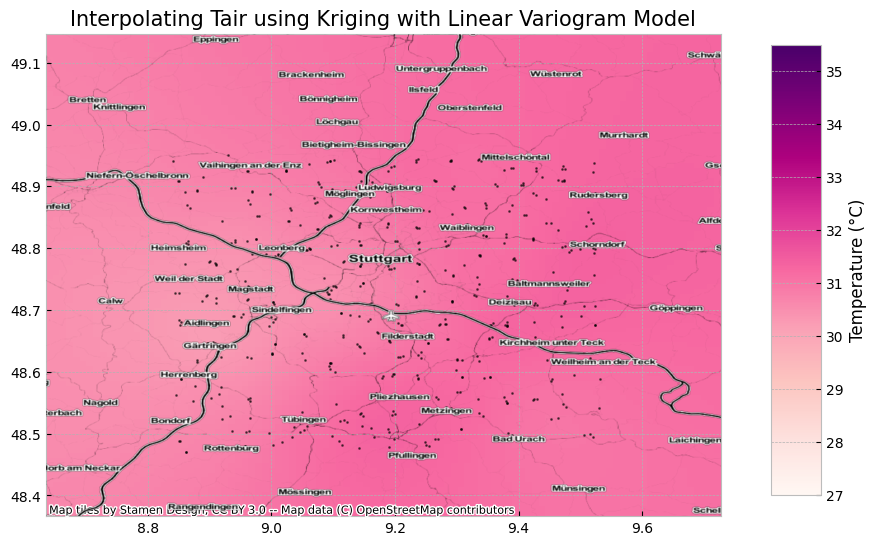

<Figure size 640x480 with 0 Axes>

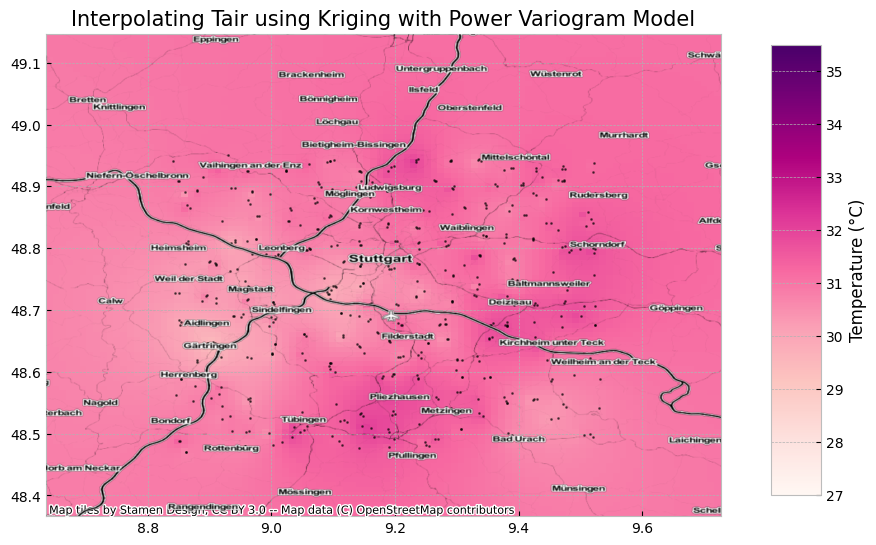

<Figure size 640x480 with 0 Axes>

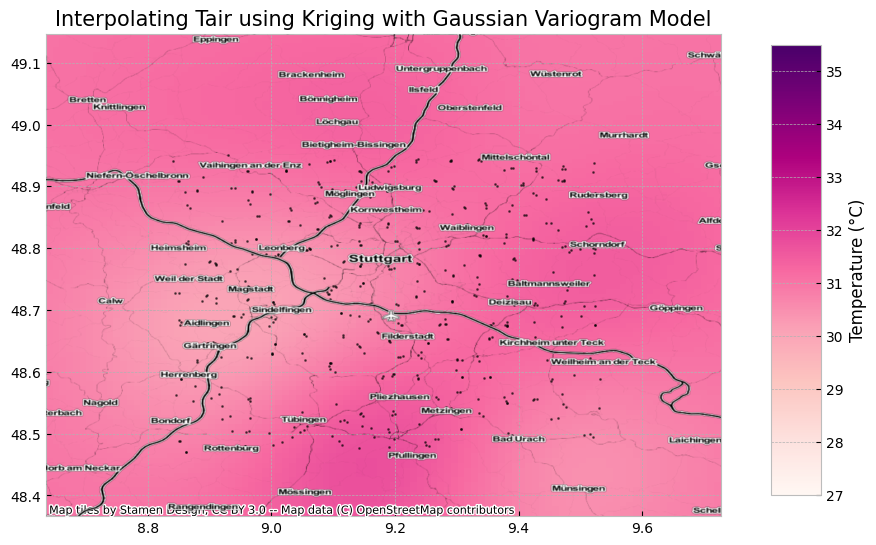

<Figure size 640x480 with 0 Axes>

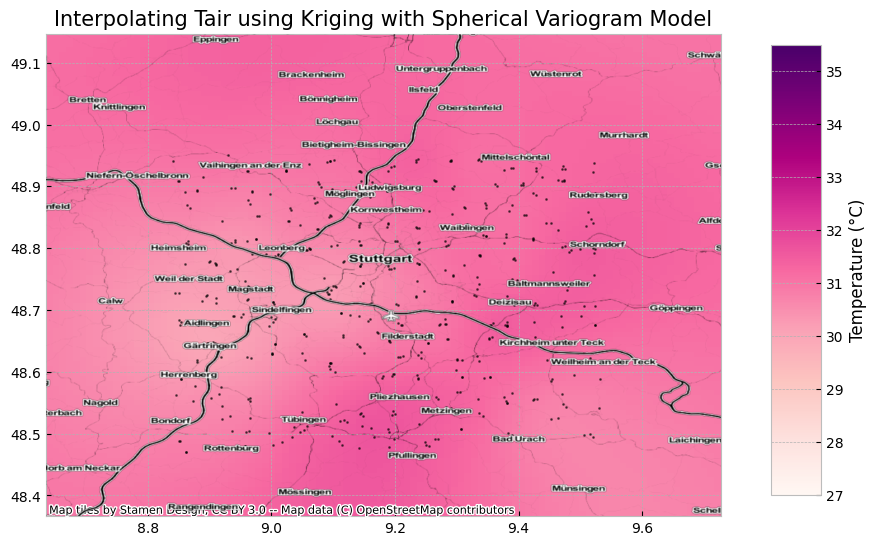

<Figure size 640x480 with 0 Axes>

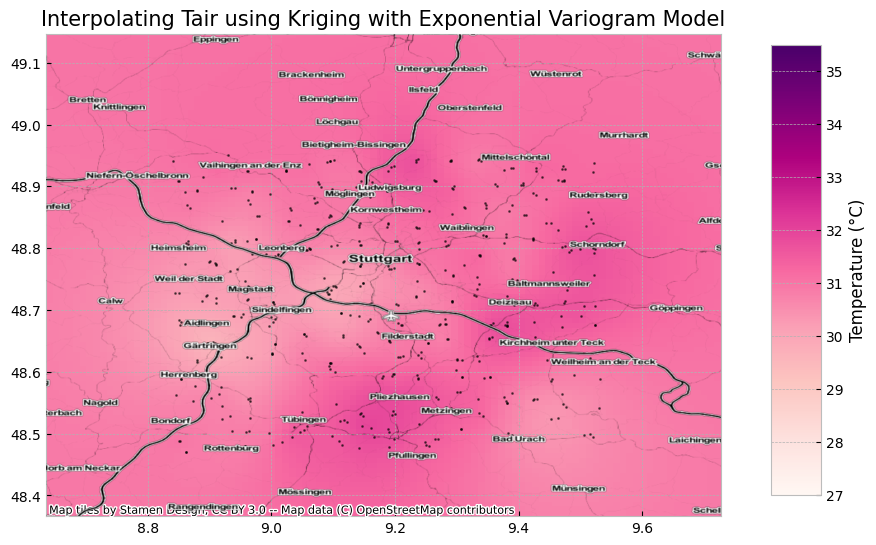

\begin{tabular}{lrr}
\toprule
variogram\_model &     RMSE &       R2 \\
\midrule
         linear & 1.755625 & 0.069626 \\
          power & 1.610189 & 0.217386 \\
       gaussian & 1.747055 & 0.078687 \\
      spherical & 1.723521 & 0.103342 \\
    exponential & 1.673280 & 0.154855 \\
\bottomrule
\end{tabular}



/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_25713/2067479563.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(variogram_errors.to_latex(index=False))


In [212]:
krigin_gdf = netatmo_df.copy()
target_feature = 'temperature'
variogram_results = []

# Interpolate temperature data using ordinary kriging with various variogram models to compare r2 scores
raster_pk_extent_l, raster_pk_l, x_coords_l, y_coords_l, coords_train_l, coords_test_l, value_train_l, value_test_l, Z_pk_krig_l, sigma_squared_p_krig_l, poly_shapely_l = interpolate_ordinary_kriging(
    krigin_gdf, 'linear', target_feature=target_feature)
raster_pk_extent_p, raster_pk_p, x_coords_p, y_coords_p, coords_train_p, coords_test_p, value_train_p, value_test_p, Z_pk_krig_p, sigma_squared_p_krig_p, poly_shapely_p = interpolate_ordinary_kriging(
    krigin_gdf, 'power', target_feature=target_feature)
raster_pk_extent_g, raster_pk_g, x_coords_g, y_coords_g, coords_train_g, coords_test_g, value_train_g, value_test_g, Z_pk_krig_g, sigma_squared_p_krig_g, poly_shapely_g = interpolate_ordinary_kriging(
    krigin_gdf, 'gaussian', target_feature=target_feature)
raster_pk_extent, raster_pk_s, x_coords_s, y_coords_s, coords_train_s, coords_test_s, value_train_s, value_test_s, Z_pk_krig_s, sigma_squared_p_krig_s, poly_shapely_s = interpolate_ordinary_kriging(
    krigin_gdf, 'spherical', target_feature=target_feature)
raster_pk_extent_e, raster_pk_e, x_coords_e, y_coords_e, coords_train_e, coords_test_e, value_train_e, value_test_e, Z_pk_krig_e, sigma_squared_p_krig_e, poly_shapely_e = interpolate_ordinary_kriging(krigin_gdf, 'exponential', target_feature=target_feature)
# raster_pk_extent_h, raster_pk_h, x_coords_h, y_coords_h, coords_train_h, coords_test_h, value_train_h, value_test_h, Z_pk_krig_h, sigma_squared_p_krig_h, poly_shapely_h = interpolate_ordinary_kriging(krigin_gdf, 'hole-effect')


ge5000_clipped = krigin_gdf.clip(poly_shapely_l)

# Plot temperature kriging results
# Reset plot

cmap = plt.cm.YlOrRd  # Choose your desired colormap
vmin = np.min(krigin_gdf[target_feature])  # Minimum value of the temperature grid
vmax = np.max(krigin_gdf[target_feature])
norm = plt.Normalize(vmin=vmin, vmax=vmax)

plot_kriging_data(raster_pk_l, x_coords_l, y_coords_l, norm, 'linear', target_feature=target_feature)
plot_kriging_data(raster_pk_p, x_coords_p, y_coords_p, norm, 'power', target_feature=target_feature)
plot_kriging_data(raster_pk_g, x_coords_g, y_coords_g, norm, 'gaussian', target_feature=target_feature)
plot_kriging_data(raster_pk_s, x_coords_s, y_coords_s, norm, 'spherical', target_feature=target_feature)
plot_kriging_data(raster_pk_e, x_coords_e, y_coords_e, norm, 'exponential', target_feature=target_feature)
# plot_kriging_data(raster_pk_h, x_coords_h, y_coords_h, norm, 'hole-effect')
# fig.colorbar(mesh, cax=axs[6], label='Temperature (°C)')

variogram_errors = pd.concat(variogram_results)

print(variogram_errors.to_latex(index=False))

plt.show()